# calibrate spectra from (frequency,counts) to (velocity, temperature) and write out for baseline and conversion to LSR
#### 1/11/22 jpw

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import csv
import scipy as sp
from scipy.ndimage import median_filter
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from datetime import datetime
import pandas as pd
%matplotlib inline

In [27]:
# customize plots
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['axes.linewidth'] = 2

### functions

In [28]:
# function to convert frequency to HI radial velocity
def convert_nu_to_vrad(nu):
    nu0 = 1420.405751   # rest frequency of HI in MHz
    c = 2.99792458e5    # speed of light in km/s
    vrad = (nu0-nu) * c / nu0
    return vrad

In [29]:
# function to read in all the files in a directory and calculate the average spectrum (counts at each frequency channel)
def avespec(directory):
    # get the list of all spectra (csv files) in directory
    files = glob.glob(directory + '/*.csv')
    # you can print out the result to make sure its doing the right thing
    #print(files)
    
    # read in the first file to initialize the sum
    nu0, C_sum = np.genfromtxt(files[0], delimiter=',', unpack=True)
    
    # loop through all the other files and sum the counts
    for f in files[1:]:
        nu1, C1 = np.genfromtxt(f, delimiter=',', unpack=True)
        if np.array_equal(nu0,nu1):
            C_sum += C1
        else:
            print('Error: frequency axes are different in avespec')
            return False, False
        
    # divide by the number of files to produce the average
    C_ave = C_sum / len(files)
    
    return nu0, C_ave

In [30]:
# function to calibrate the spectra in a given subdirectory (e.g., 'lon30'); average, convert to temperature units and median filter to remove spikes
def counts2temperature(dir):
    nu, C = avespec(dir)
    
    if not np.array_equal(nu,nu_cal):
        print('Error: frequency axes are different from calibration')
        return False, False
    
    vrad = convert_nu_to_vrad(nu)
    try:
        Tsrc = median_filter(C/G - Tr, size=5)
    except:
        print('First read in caibration file to convert spectra to temperature')
    return vrad, Tsrc

### code

In [44]:
# go to data directory
path = '/Users/jpw/NG/HI/data/airspy_spectra/'
os.chdir(path)
cwd = os.getcwd()

In [32]:
# read in the receiver temperature and gain, determined from calibrate.ipynb
nu_cal, Tr, G = np.genfromtxt('calibration2.csv', delimiter=',', unpack=True)

In [33]:
# loop through the spectra, average each longitude, calibrate, and write out

for f in os.listdir():
    if os.path.isdir(f) and f[0:3] == 'lon':
        print(f)
        cal_subdir = 'calibrated_spectra'
        cal_dir = cwd + '/' + cal_subdir
        if not os.path.isdir(cal_dir):
            print('Creating subdirectory', cal_subdir, ' in ', cwd)
            os.mkdir(cal_dir)

        v, T = counts2temperature(f)
        ff = f+'_cal.csv'
        print('Writing calibrated spectrum to ', ff)
        with open(cal_dir + '/' + ff, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(zip(v[::-1], T[::-1]))

lon15
Creating subdirectory calibrated_spectra  in  /Users/jpw/NG/HI/data/airspy_spectra
Writing calibrated spectrum to  lon15_cal.csv
lon70
Writing calibrated spectrum to  lon70_cal.csv
lon25
Writing calibrated spectrum to  lon25_cal.csv
lon85
Writing calibrated spectrum to  lon85_cal.csv
lon40
Writing calibrated spectrum to  lon40_cal.csv
lon40_extra
Writing calibrated spectrum to  lon40_extra_cal.csv
lon65
Writing calibrated spectrum to  lon65_cal.csv
lon55
Writing calibrated spectrum to  lon55_cal.csv
lon90
Writing calibrated spectrum to  lon90_cal.csv
lon30
Writing calibrated spectrum to  lon30_cal.csv
lon45
Writing calibrated spectrum to  lon45_cal.csv
lon80
Writing calibrated spectrum to  lon80_cal.csv
lon20
Writing calibrated spectrum to  lon20_cal.csv
lon75
Writing calibrated spectrum to  lon75_cal.csv
lon10
Writing calibrated spectrum to  lon10_cal.csv
lon65_first_try
Writing calibrated spectrum to  lon65_first_try_cal.csv
lon35
Writing calibrated spectrum to  lon35_cal.csv
l

<Figure size 432x288 with 0 Axes>

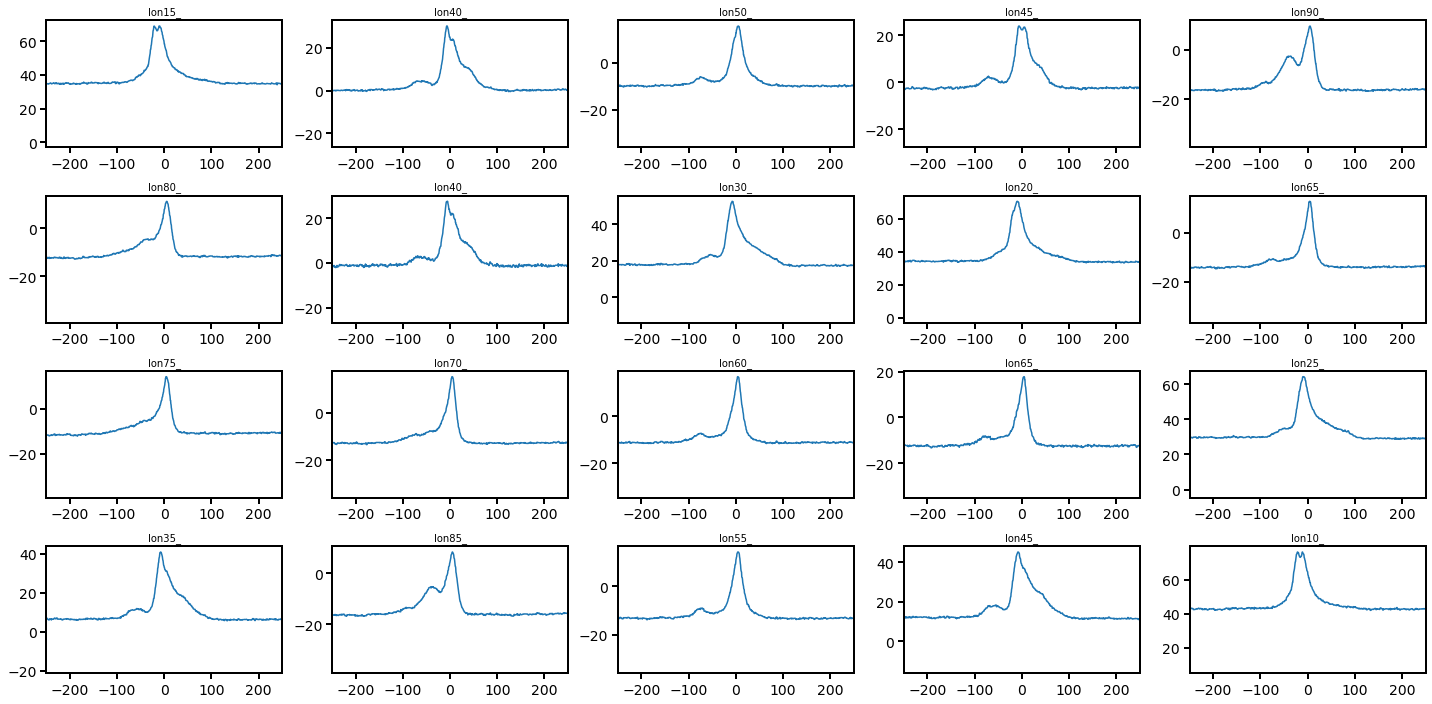

In [35]:
# look at the flattened spectra
# and determine the velocity range for doing the next (baseline) step
plt.clf()
files = glob.glob('calibrated_spectra/*.csv')
nfiles = len(files)
fig = plt.figure(figsize=(20,12))
ny = 5
nx = nfiles/5 + 1

for n,f in enumerate(files):
    v, T = np.genfromtxt(f, delimiter=',', unpack=True)
    ax = fig.add_subplot(int(nx), int(ny), int(n+1))
    ax.plot(v, T)
    label = f.split('/')[1][:6]
    ax.set_title(label, fontsize=10)
    ax.set_xlim(-250,250)
    #ax.set_ylim(0.85,1.05)
plt.tight_layout()
plt.savefig('calibrated_spectra.png')

(-5.0, 5.0)

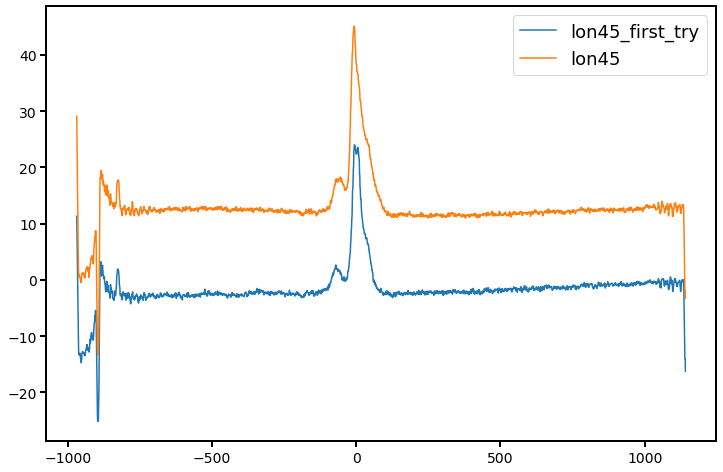

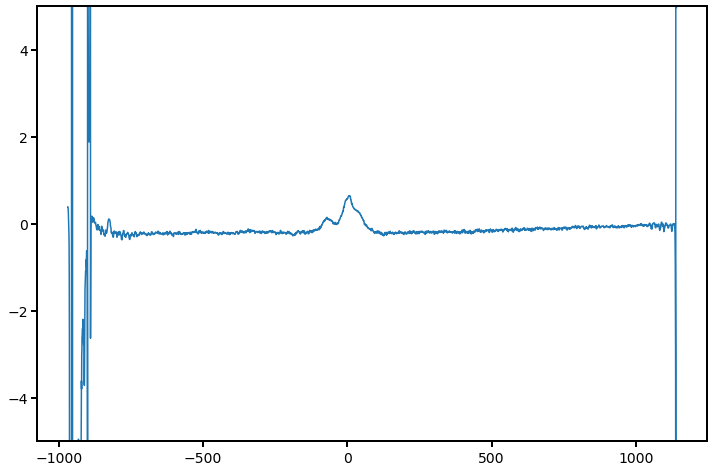

In [43]:
# compare a few cases where there were different datasets at the same position
file1 = 'lon45_first_try'
file2 = 'lon45'
#file1 = 'lon65_first_try'
#file2 = 'lon65'

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
v1, T1 = np.genfromtxt('calibrated_spectra/'+file1+'_cal.csv', delimiter=',', unpack=True)
ax.plot(v1, T1, label=file1)
v2, T2 = np.genfromtxt('calibrated_spectra/'+file2+'_cal.csv', delimiter=',', unpack=True)
ax.plot(v2, T2, label=file2)
ax.legend()

fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(111)
ax2.plot(v1, T1/T2)
ax2.set_ylim(-5,5)
